In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import torch as torch
import math as mathe
import itertools

In [2]:
# Add project root path if not already present
PROJECT_ROOT = os.path.abspath("..")  # move up one level from notebooks/
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Visual confirmation
print("[✓] Project located at:", PROJECT_ROOT)

from src.data.load_data import load_train_data, load_test_data
from src.data.stratified_split import stratified_split_pad_torch
from src.models.model_trainer import Trainer
from src.models.model_1 import ECGNet
from src.models.model_2 import TCN_STFT_Classifier
from src.models.hyperparamter_tunning import hyperparameter_search

[✓] Project located at: c:\Users\toby_\Documents\TU_Berlin\Semestre 3\AMLS\AMLS_packed


In [3]:
X_train, y_train = load_train_data()

durations = np.array([len(x) / 300 for x in X_train])

cls_count = y_train[0].groupby(y_train[0]).count()

[✓] Loaded X_train with 6179 sequences
[✓] Loaded y_train with shape (6179, 1)


Here we clearly see that the classes are imbalanced. The healthy ECG class has 3638 samples, while the tachycardia class only has 549. The other abnormal behaviors class has 1765, and the noise class has 227. This is also relevant because the histograms will have different counts, even if the distributions behave similarly.

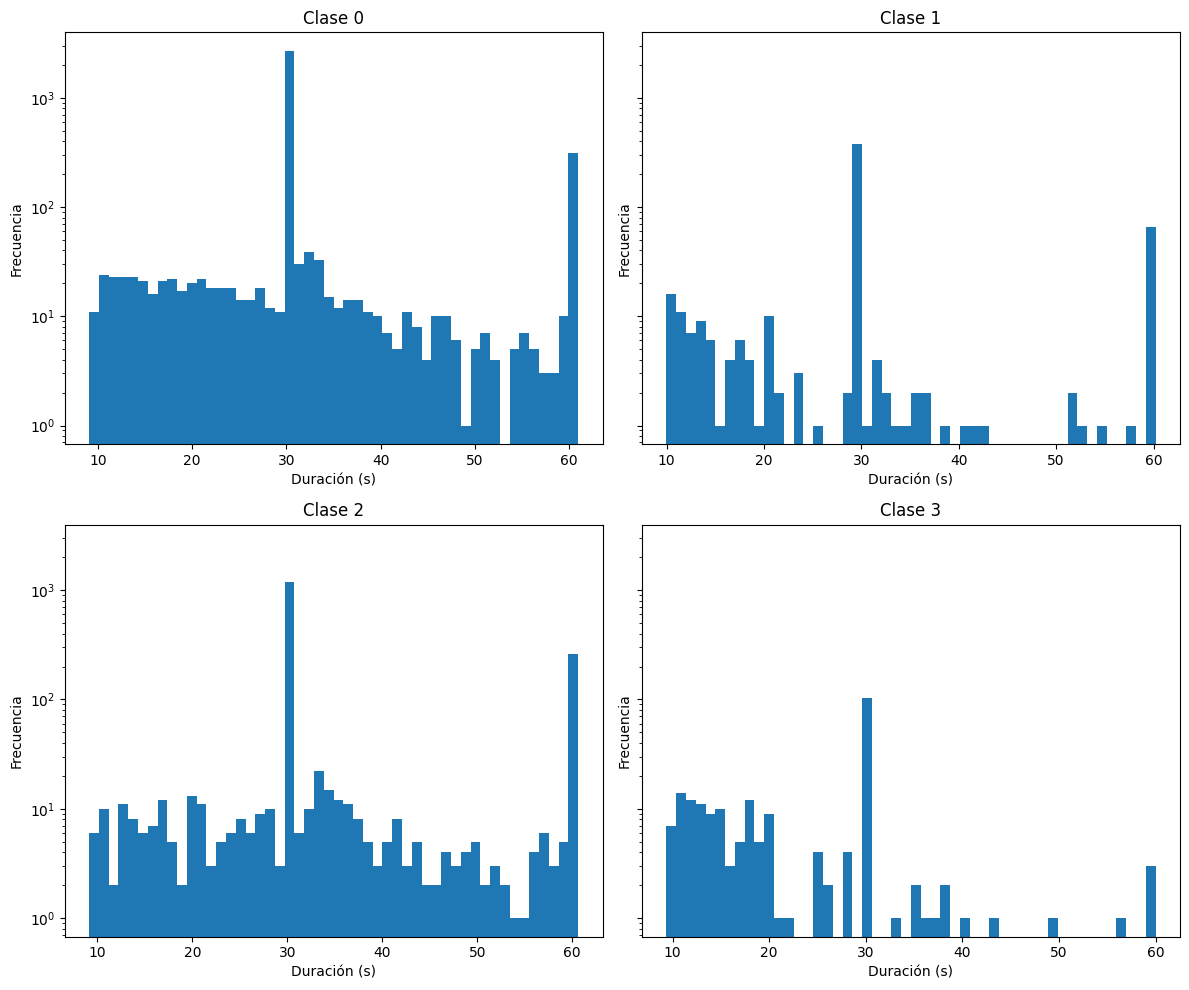

In [4]:
classes = np.unique(y_train[0])
n_classes = len(classes)
y_train_py = y_train[0].values

rows = int(np.ceil(n_classes / 2))
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, cls in enumerate(classes):
    ax = axes[i]
    ax.hist(durations[y_train_py == cls], bins=50)
    ax.set_title(f"Clase {cls}")
    ax.set_xlabel("Duración (s)")
    ax.set_ylabel("Frecuencia")
    ax.set_yscale("log")

# Oculta los ejes vacíos si hay
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

Most ECG signals last 30 or 60 seconds across all classes, but this trend is less clear for signals that are classified as noise only. However, for tachycardic ECG signals, there are few examples with durations between 30 and 60 seconds, and there are also gaps between 20 and 30 seconds — unlike healthy signals, which show a broad distribution of durations with many examples across the entire range.

A similar pattern emerges when comparing abnormal signals to pure noise. The abnormal signals are more evenly distributed across durations from 10 to 30 and 30 to 60 seconds, with clear peaks at 30 and 60 seconds. In contrast, noise signals show gaps in the 20 to 30 and 30 to 60 second ranges.

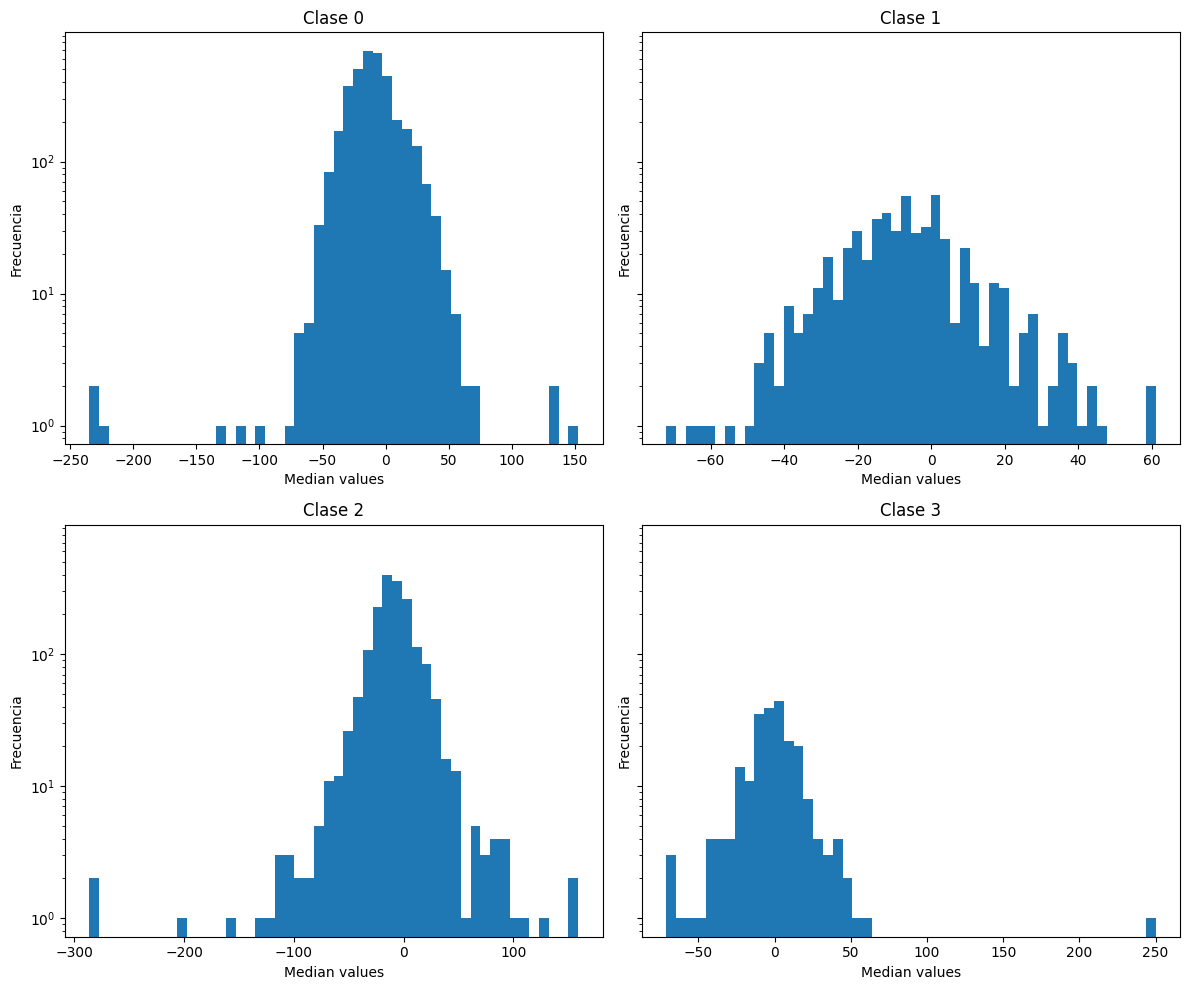

In [ ]:
medians = [np.median(x) for x in X_train]

mins = [np.min(x) for x in X_train]

maxs = [np.max(x) for x in X_train]

deviaton = [np.std(x) for x in X_train]

fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, clase in enumerate(np.unique(y_train)):

    ax = axes[i]

    ax.hist(np.array(medians)[y_train_py == clase], bins=50)

    ax.set_title(f"Clase {clase}")

    ax.set_xlabel("Median values")

    ax.set_ylabel("Frecuencia")

    ax.set_yscale("log")

plt.tight_layout()

plt.show()

Now we are looking at the values that most commonly appear in each electrocardiogram. We can see that for healthy ECGs, there are quite a few cases where the median value falls in extreme ranges. The same holds true for the other classes — except for the noise class.

However, these extreme values differ between classes. For healthy signals, the extremes are around -250 and 150, but for tachycardic signals, the extremes are only between -60 and 60 — a significant difference. In signals with other abnormal patterns, the extreme values are again broader, ranging from -300 to 120.

If we disregard those extreme values, all classes behave fairly normally — except for the noise class, which is skewed to the right.

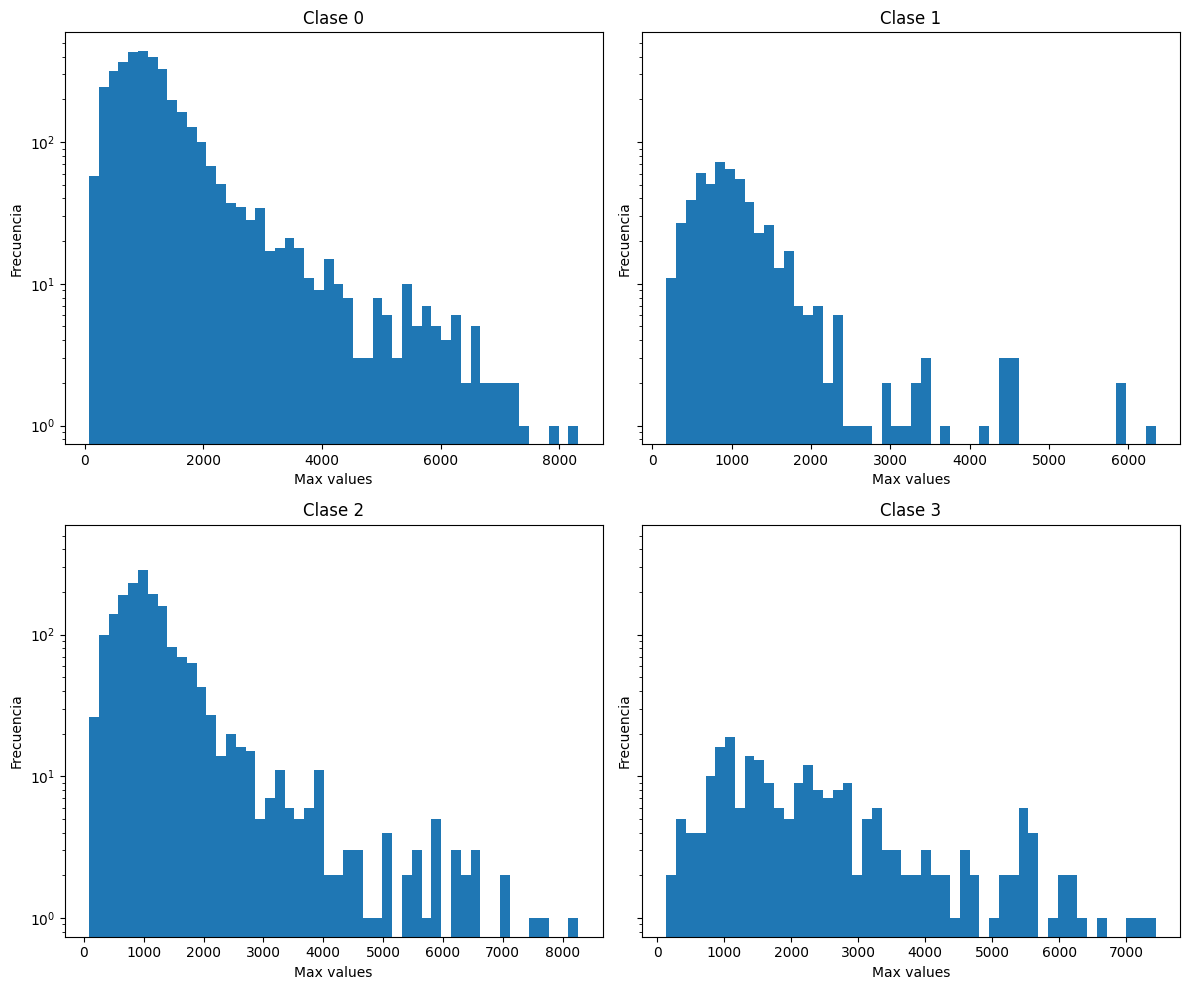

In [ ]:
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, clase in enumerate(np.unique(y_train)):

    ax = axes[i]

    ax.hist(np.array(maxs)[y_train_py == clase], bins=50)

    ax.set_title(f"Clase {clase}")

    ax.set_xlabel("Max values")

    ax.set_ylabel("Frecuencia")

    ax.set_yscale("log")

plt.tight_layout()

plt.show()

This plot closely matches the previous one, as the maximum values in most tachycardic ECGs almost never exceed 5000 — unlike the healthy ones and those with other abnormalities. However, these three classes once again share a similar distribution, although this time they are right-skewed, and noise once again does not follow the same distribution as the others.

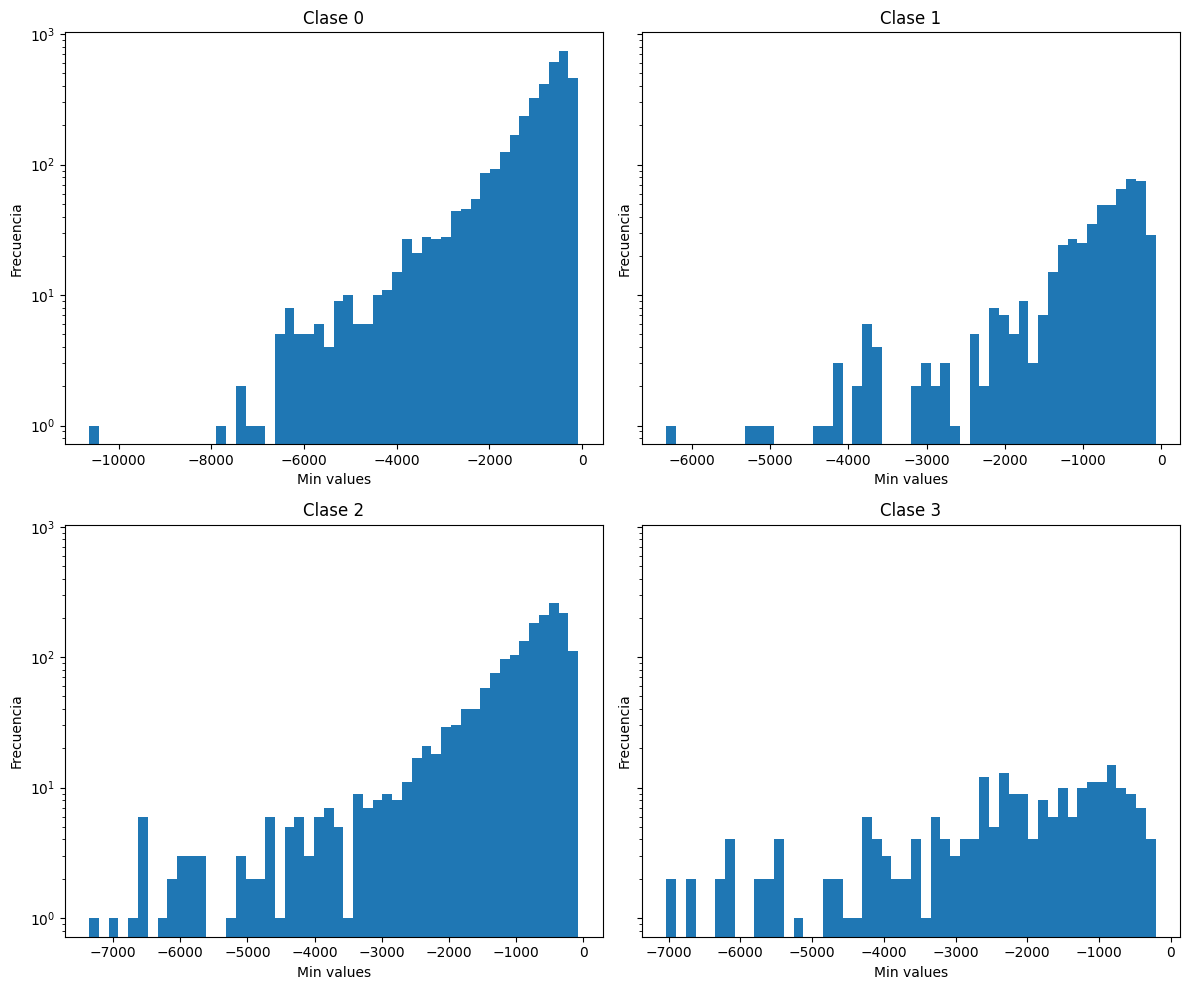

In [ ]:
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, clase in enumerate(np.unique(y_train)):

    ax = axes[i]

    ax.hist(np.array(mins)[y_train_py == clase], bins=50)

    ax.set_title(f"Clase {clase}")

    ax.set_xlabel("Min values")

    ax.set_ylabel("Frecuencia")

    ax.set_yscale("log")

plt.tight_layout()

plt.show()

This plot also corresponds with the previous two. The tachycardia ECG class has most of its minimum values between 0 and -4000, while the healthy and other abnormal classes range from 0 to -8000 and -7000, respectively. All of these show a left-skewed distribution. For the noise class, no skewed distribution is observed; instead, it appears more uniform.

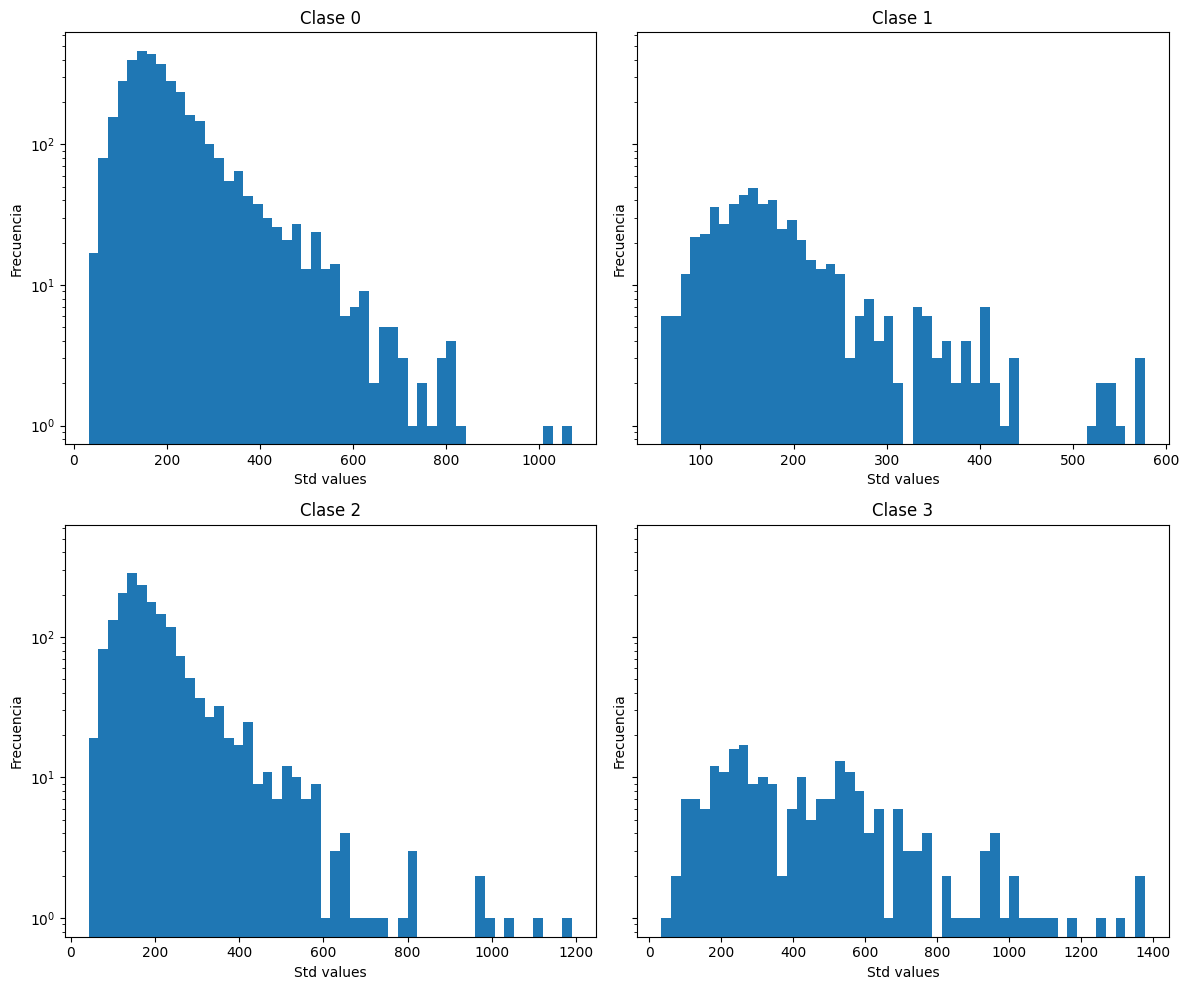

In [ ]:
fig, axes = plt.subplots(rows, 2, figsize=(12, 5 * rows), sharey=True)

axes = axes.flatten()

for i, clase in enumerate(np.unique(y_train)):

    ax = axes[i]

    ax.hist(np.array(deviaton)[y_train_py == clase], bins=50)

    ax.set_title(f"Clase {clase}")

    ax.set_xlabel("Std values")

    ax.set_ylabel("Frecuencia")

    ax.set_yscale("log")

plt.tight_layout()

plt.show()

In conclusion, we have imbalanced classes, with many more recordings for the healthy ECGs. The first three classes have similar distributions for the mean, minimum, and maximum values, although the difference lies in the extreme values they reach. The noise recordings show a very different distribution in these cases.

Finally, the duration of the electrocardiograms in each class is mostly 30 or 60 seconds, but with the distinction that the healthy and other abnormal classes have durations spread across a wide range, whereas for tachycardia and noise, most durations are concentrated at 30 or 60 seconds.

In [5]:
X_train, X_val, lengths_train, lengths_val, y_train, y_val = stratified_split_pad_torch(
    X_train, y_train
)

print(X_train.shape, y_train.shape)


class EDGCDataset(torch.utils.data.Dataset):

    def __init__(self, X, lengths, y):

        self.X = X

        self.lengths = lengths

        self.y = y

    def __len__(self):

        return len(self.X)

    def __getitem__(self, idx):

        return self.X[idx], self.lengths[idx], self.y[idx]


train_dataset = EDGCDataset(X_train, lengths_train, y_train)
val_dataset = EDGCDataset(X_val, lengths_val, y_val)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

torch.Size([5564, 18286]) torch.Size([5564, 1])
